In [1]:
#biblitecas
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

drive.mount('/content/drive')
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/amostra_nba_2.xlsx')
df_teste = pd.read_excel('/content/drive/My Drive/Colab Notebooks/amostra_nba_testeknn.xlsx')

Mounted at /content/drive


### Base treino

In [2]:
# base de treino

# Removendo os outliers

Q1 = df[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']].quantile(0.25)
Q3 = df[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']].quantile(0.75)

IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_sem_outliers = df[['Pos_y','AST','REB','TOV','STL','BLK','PF','Altura','Peso']][~((df[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']] < limite_inferior)
                 | (df[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']] > limite_superior)).any(axis=1)]



### Base teste

In [3]:
#base de teste

# Removendo os outliers

df_teste.fillna(0,inplace = True)
df_teste_ajust = df_teste[(df_teste['GP']>20) & (df_teste['Temporadas']> 4 )]

Q1 = df_teste_ajust[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']].quantile(0.25)
Q3 = df_teste_ajust[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']].quantile(0.75)

IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


df_sem_outliers_teste = df_teste_ajust[['Pos_y','AST','REB','TOV','STL','BLK','PF','Altura','Peso']][~((df_teste_ajust[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']] < limite_inferior)
                 | (df_teste_ajust[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']] > limite_superior)).any(axis=1)]

### Cross Validation

In [18]:
# Separando as variáveis
X = df_sem_outliers[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']]
y = df_sem_outliers['Pos_y']

# Testar diferentes depth e sample
depths = range(1, 21)
scores = []
for depth in depths:
    tree = DecisionTreeClassifier(
        max_depth=depth, max_features  = 3, min_samples_split = 10
        )
    score = cross_val_score(tree, X, y, cv=5)
    scores.append(score.mean())



In [19]:
#utilizando apenas valores acima do 3 quantil
pontos_final = []
score_final = []
statistics.mean(scores)
for i in range(len(scores)):
  if scores[i] > np.quantile(scores, 0.75):
    score_final.append(scores[i])
  else: continue

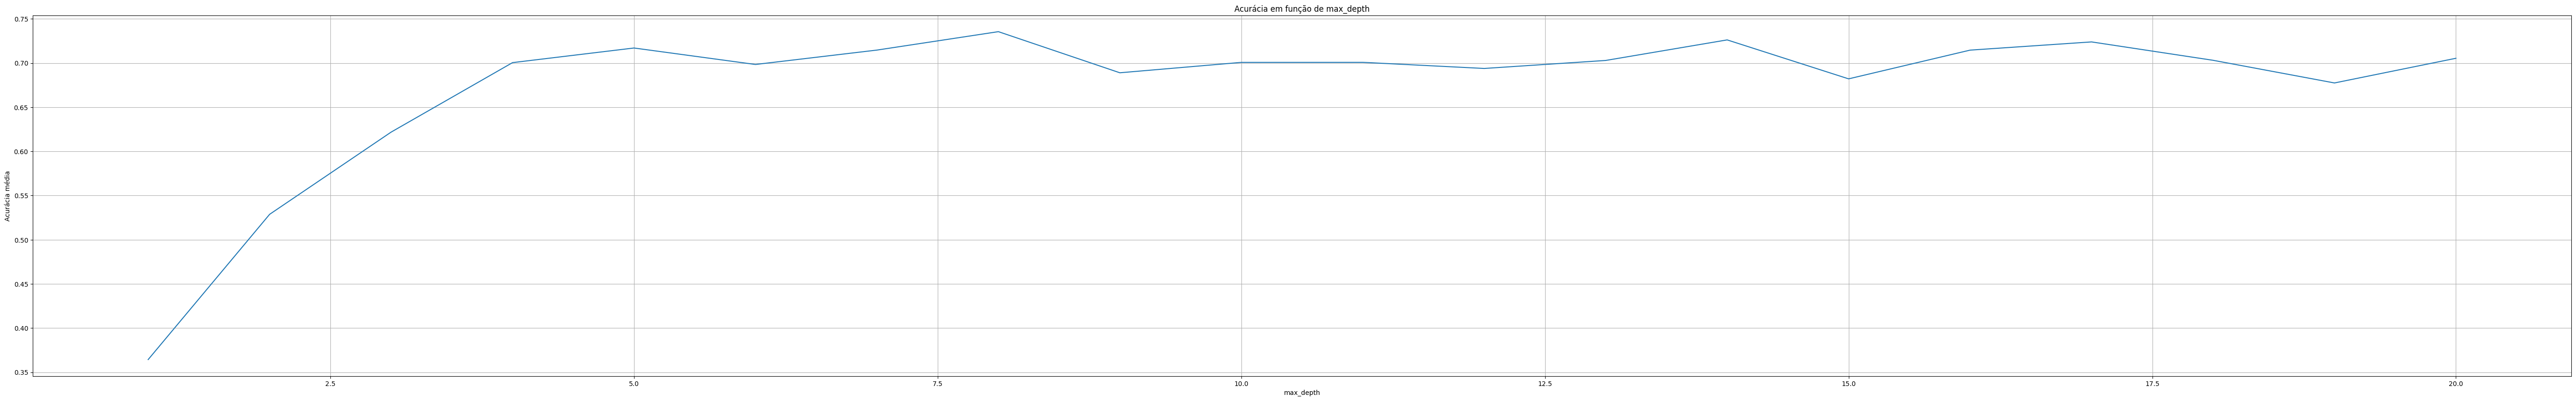

In [20]:
plt.figure(figsize=(70, 10))
plt.plot(depths,scores)
plt.xlabel('max_depth')
plt.ylabel('Acurácia média')
plt.title('Acurácia em função de max_depth')
plt.grid()
plt.show()

### AD usando VR

In [21]:
#modelo de árvore de decisão
model = DecisionTreeClassifier(splitter = 'best',
                               min_samples_split = 20 ,
                                max_depth= 5,
                               max_features  = 'sqrt',
                               random_state=42)

model.fit(X, y)

DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_split=20,
                       random_state=42)

In [22]:
plt.figure(figsize=(100, 100))
plot_tree(model, feature_names=X.columns, class_names=['C','PG','PF','SG','SF'], filled=True)
plt.show()

In [23]:
model.get_params(deep=True)

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [24]:
model.score(X, y)

0.7378190255220418

In [25]:
#analisando amostra de treino
df_sem_outliers_teste.value_counts('Pos_y')

,count
Pos_y,
PF,137
SG,121
C,99
PG,79
SF,31


In [26]:
#Realizando uma amostra artifical para igualar as classes
X_teste = df_sem_outliers_teste[['AST','REB','TOV','STL','BLK','PF','Altura','Peso']]
y_teste = df_sem_outliers_teste['Pos_y']

smote = SMOTE(random_state=42)
X_teste_ra, y_teste_ra = smote.fit_resample(X_teste, y_teste)

#amostra teste apos o SMOTE
print(pd.Series(y_teste_ra).value_counts())

#predições no conjunto de teste
y_pred = model.predict(X_teste_ra)

# accuracy
print(f'\n Acurácia: {accuracy_score(y_teste_ra, y_pred)*100:.2f}%')

#matriz de confusão e o metricas do modelo
print("Matriz de Confusão:")
print(confusion_matrix(y_teste_ra, y_pred))

print("\nRelatório de Classificação:\n")
print(classification_report(y_teste_ra, y_pred))


Pos_y
SF    137
PF    137
SG    137
PG    137
C     137
Name: count, dtype: int64

 Acurácia: 51.68%
Matriz de Confusão:
[[117  19   0   1   0]
 [ 44  23   2  65   3]
 [  0   1 110   9  17]
 [  9  33   1  48  46]
 [  0   9  44  28  56]]

Relatório de Classificação:

              precision    recall  f1-score   support

           C       0.69      0.85      0.76       137
          PF       0.27      0.17      0.21       137
          PG       0.70      0.80      0.75       137
          SF       0.32      0.35      0.33       137
          SG       0.46      0.41      0.43       137

    accuracy                           0.52       685
   macro avg       0.49      0.52      0.50       685
weighted avg       0.49      0.52      0.50       685



### AD usando CP

#### Base treino

In [ ]:
#matriz não normalizada
df_posicao = df_sem_outliers[df['Pos_y'].isin(['PF','PG','SF','SG','C'])][['Pos_y','AST',	'REB',	'TOV',	'STL',	'BLK',	'PF', 'Altura',	'Peso']]
df_stat = df_posicao.groupby('Pos_y').mean()


#matriz padronizada
df_padrao = df_stat.copy()
for col in list(df_padrao.columns):
  media = df_padrao[col].mean()
  desvp = df_padrao[col].std()
  for index,row in df_padrao.iterrows():
    pdz = (row[col] - media)/desvp
    df_padrao[col][index] = pdz

pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_padrao)

df_comp = pd.DataFrame(columns=list(df_padrao.columns))
for cp in pca.components_:
  df_comp.loc[len(df_comp)] = cp
df_comp

df_jogadores = df[df['Pos_y'].isin(['PF','PG','SF','SG','C'])][['Pos_y','AST',	'REB',	'TOV',	'STL',	'BLK',	'PF', 'Altura',	'Peso']]

for col in ['AST',	'REB',	'TOV',	'STL',	'BLK',	'PF', 'Altura',	'Peso']:
  media = df_jogadores[col].mean()
  desvp = df_jogadores[col].std()
  for index,row in df_jogadores.iterrows():
    pdz = (row[col] - media)/desvp
    df_jogadores[col][index] = pdz

df_jogadores['CP1'],df_jogadores['CP2'],df_jogadores['CP3'] = 0,0,0

for index,row in df_jogadores.iterrows():
  pc1,pc2,pc3 = 0,0,0
  for col in ['AST',	'REB',	'TOV',	'STL',	'BLK',	'PF', 'Altura',	'Peso']:
    pc1 += row[col]*df_comp.loc[0][col]
    pc2 += row[col]*df_comp.loc[1][col]
    pc3 += row[col]*df_comp.loc[2][col]
  df_jogadores['CP1'][index],df_jogadores['CP2'][index],df_jogadores['CP3'][index] = pc1,pc2,pc3

#### Base teste

In [ ]:
#matriz não normalizada
df_posicao = df_sem_outliers_teste[df_sem_outliers_teste['Pos_y'].isin(['PF','PG','SF','SG','C'])][['Pos_y','AST',	'REB',	'TOV',	'STL',	'BLK',	'PF', 'Altura',	'Peso']]
df_teste_ajust = df_posicao.copy()
for col in ['AST',	'REB',	'TOV',	'STL',	'BLK',	'PF', 'Altura',	'Peso']:
  media = df_teste_ajust[col].mean()
  desvp = df_teste_ajust[col].std()
  for index,row in df_teste_ajust.iterrows():
    pdz = (row[col] - media)/desvp
    df_teste_ajust[col][index] = pdz


df_teste_ajust['CP1'],df_teste_ajust['CP2'],df_teste_ajust['CP3'] = 0,0,0

for index,row in df_teste_ajust.iterrows():
  pc1,pc2,pc3 = 0,0,0
  for col in ['AST',	'REB',	'TOV',	'STL',	'BLK',	'PF', 'Altura',	'Peso']:
    pc1 += row[col]*df_comp.loc[0][col]
    pc2 += row[col]*df_comp.loc[1][col]
    pc3 += row[col]*df_comp.loc[2][col]
  df_teste_ajust['CP1'][index],df_teste_ajust['CP2'][index],df_teste_ajust['CP3'][index] = pc1,pc2,pc3
df_teste_ajust

#### Modelo CP

In [29]:
# Separando as variáveis independentes (X) e dependentes (y)
X_2 = df_jogadores[['CP1','CP2','CP3']]  # Variáveis independentes
y_2 = df_jogadores['Pos_y']  # Variável dependente


# Criando o modelo de árvore de decisão
model = DecisionTreeClassifier(splitter = 'best',
                               min_samples_split = 20 ,
                                max_depth= 5,
                               random_state=42)

# Treinando o modelo
model.fit(X_2, y_2)

DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=42)

In [30]:
model.score(X_2, y_2)

0.7936507936507936

In [31]:
#prevendo usando conjunto teste
X_teste_2 = df_teste_ajust[['CP1','CP2','CP3']]
y_teste_2 = df_teste_ajust['Pos_y']

# Aplicando o SMOTE para aumentar a classe SF
smote = SMOTE(random_state=42)
X_teste_ra_2, y_teste_ra_2 = smote.fit_resample(X_teste_2, y_teste_2)

#amostra teste apos o SMOTE
print(pd.Series(y_teste_ra_2).value_counts())

#predições no conjunto de teste
y_pred_2 = model.predict(X_teste_ra_2)

# accuracy
print(f'\n Acurácia: {accuracy_score(y_teste_ra_2, y_pred_2)*100:.2f}%')

#matriz de confusão e o metricas do modelo
print("Matriz de Confusão:")
print(confusion_matrix(y_teste_ra_2, y_pred_2))
print("\nRelatório de Classificação:\n")
print(classification_report(y_teste_ra_2, y_pred_2))

Pos_y
SF    137
PF    137
SG    137
PG    137
C     137
Name: count, dtype: int64

 Acurácia: 56.93%
Matriz de Confusão:
[[109  28   0   0   0]
 [ 31  53   1  51   1]
 [  1   0 107   9  20]
 [  1  30   0  72  34]
 [  3   5  41  39  49]]

Relatório de Classificação:

              precision    recall  f1-score   support

           C       0.75      0.80      0.77       137
          PF       0.46      0.39      0.42       137
          PG       0.72      0.78      0.75       137
          SF       0.42      0.53      0.47       137
          SG       0.47      0.36      0.41       137

    accuracy                           0.57       685
   macro avg       0.56      0.57      0.56       685
weighted avg       0.56      0.57      0.56       685

